# Efficient epidemic state representation algorithm

## Load modules

In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/julia_codes/SmallCouplingDynamicCavity`


In [30]:
using SmallCouplingDynamicCavity
using Plots, LaTeXStrings
using Graphs, GraphRecipes
using Distributions
using SparseArrays

## Graph generation

In [3]:
NV = 100 # number of graph vertices
k = 3 # degree

# generate a random graph with NV vertices and NE edges
G = random_regular_graph(NV, k)

{100, 150} undirected simple Int64 graph

## - SI:

### System parameter definition and simulation

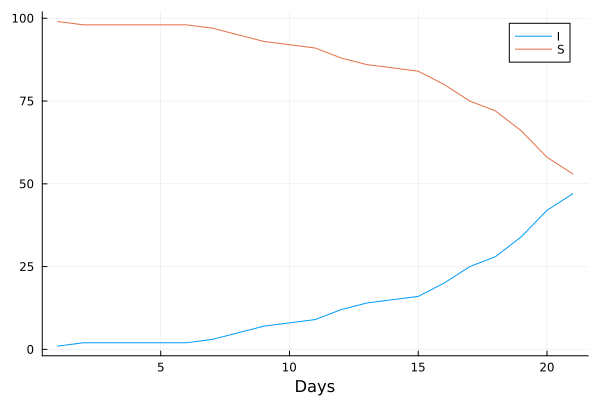

In [8]:
# define the constants
T::Int = 20 # total time
fₚ::Float64 = 0.0 # false-positive rate
fₙ::Float64 = 0.0 # false-negative rate
γ::Float64 = 1/NV # Patient zero probability
λ₀::Float64 = 0.2 # Infection rate
ε_autoinf::Float64 = 1e-10 # Self-infection rate
Nobs::Int = ceil(NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob::Float64, x::Float64; fₚ::Float64 = fₚ, fₙ::Float64 = fₙ)
    if Ob == 0.0
        return (1-fₚ)*(1-x) + fₙ*x
    elseif  Ob == 1.0
        return fₚ*(1-x) + (1-fₙ)*x
    elseif Ob == -1.0
        return 1.0
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SI(ε_autoinf, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, patient_zero=[1])

# generate observations at the last time
obsmat = ones(nv(G), T+1) * (-1.0)
for (iₗ, τₗ) in sample(collect(Iterators.product(1:NV,ceil(Int,T*.5):T+1)), Nobs, replace = false)
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

# insert the observations into the model structure
model.obsmat .= obsmat

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
plot([nrI nrS], xlabel = "Days", ylabel = "", label = ["I" "S"])

### Inference

i = 1 ε = 0.9
i = 2 ε = 1.3061237193032966
i = 3 ε = 1.101500163052245
i = 4 ε = 1.0722531781679456
i = 5 ε = 1.0565472778846043
i = 6 ε = 0.6304134937445527
i = 7 ε = 0.483522489447926
i = 8 ε = 0.18156814474735228
i = 9 ε = 0.1563839423586223
i = 10 ε = 0.10198839497670376
i = 11 ε = 0.1082622604539174
i = 12 ε = 0.08216166569921723
i = 13 ε = 0.040117371104058
i = 14 ε = 0.033309590197262096
i = 15 ε = 0.019346232567182153
i = 16 ε = 0.007345632656689527
i = 17 ε = 0.0037635537017302297
i = 18 ε = 0.0018787063168652432
i = 19 ε = 0.0006934175883083205
i = 20 ε = 0.0005504726006896332
i = 21 ε = 0.0003316232699624999
i = 22 ε = 0.00017429279676086512
i = 23 ε = 7.076825183690433e-5
i = 24 ε = 2.4591602507562094e-5
i = 25 ε = 1.9396020027762084e-5
i = 26 ε = 9.613952652734806e-6
i = 27 ε = 5.063001506955614e-6
i = 28 ε = 1.4737369917749987e-6
i = 29 ε = 9.141355269415286e-7
i = 30 ε = 5.177402999656522e-7
i = 31 ε = 2.7425559273597244e-7
i = 32 ε = 1.0377410186723779e-7
i = 33 ε = 5.4

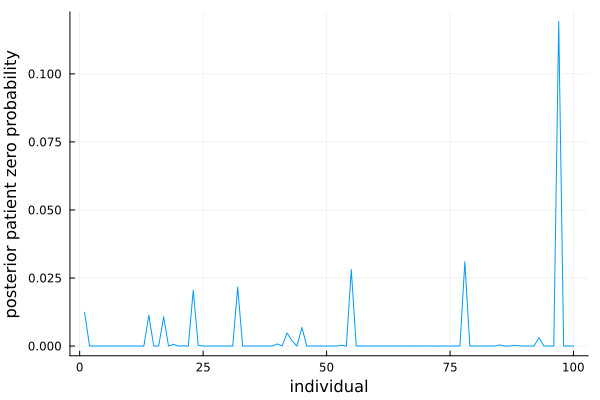

In [9]:
# computational constants
epsconv::Float64 = 1e-10 # convergence threshold
maxiter::Int = 5e2 # max number of iterations
damp::Float64 = 0.1 # damping factor
μ_cutoff::Float64 = -1 # cutoff for convergence

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

patient_zero_prob = [node.marg.m[2,1] for node in nodes]

plot(patient_zero_prob, xlabel = "individual", ylabel = "posterior patient zero probability", label = "")

## - SIS:

### System parameter definition and simulation

Matrix{Float64}
Matrix{Float64}


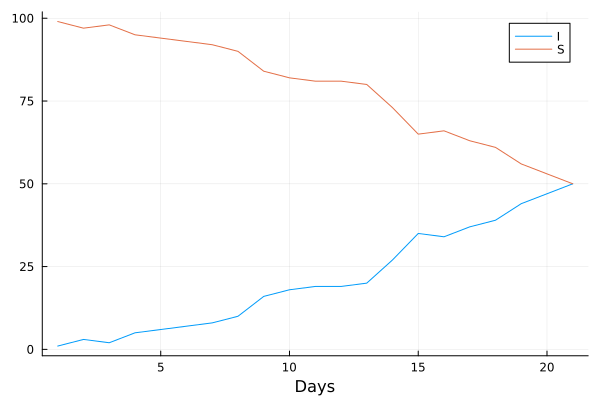

In [15]:
# define the constants
T::Int = 20 # total time
fₚ::Float64 = 0.0 # false-positive rate
fₙ::Float64 = 0.0 # false-negative rate
γ::Float64 = 1/NV # Patient zero probability
λ₀::Float64 = 0.2 # Infection rate
r₀::Float64 = 0.1 # Recovery rate
ε_autoinf::Float64 = 1e-10 # Self-infection rate
Nobs::Int = ceil(NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob::Float64, x::Float64; fₚ::Float64 = fₚ, fₙ::Float64 = fₙ)
    if Ob == 0.0
        return (1-fₚ)*(1-x) + fₙ*x
    elseif  Ob == 1.0
        return fₚ*(1-x) + (1-fₙ)*x
    elseif Ob == -1.0
        return 1.0
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SIS(ε_autoinf, r₀, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, patient_zero=[1])

# generate observations at the last time
obsmat = ones(nv(G), T+1) * (-1.0)
for (iₗ, τₗ) in sample(collect(Iterators.product(1:NV,ceil(Int,T*.5):T+1)), Nobs, replace = false)
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

# insert the observations into the model structure
model.obsmat .= obsmat

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
plot([nrI nrS], xlabel = "Days", ylabel = "", label = ["I" "S"])

### Inference

i = 1 ε = 0.9900102113338254
i = 2 ε = 1.270926515627948
i = 3 ε = 1.1779375352212587
i = 4 ε = 1.098206056339302
i = 5 ε = 0.5198628580002287
i = 6 ε = 0.3209860073906361
i = 7 ε = 0.2444946113172457
i = 8 ε = 0.1452448004937189
i = 9 ε = 0.20245769638220545
i = 10 ε = 0.12548048875082674
i = 11 ε = 0.048884008029859594
i = 12 ε = 0.0189313735988782
i = 13 ε = 0.009849643114416717
i = 14 ε = 0.008072101097249929
i = 15 ε = 0.005826558023994122
i = 16 ε = 0.0028582556424074923
i = 17 ε = 0.0013400094215753056
i = 18 ε = 0.0007004922671129954
i = 19 ε = 0.0005426276624752036
i = 20 ε = 0.0006339687594362209
i = 21 ε = 0.0004759420044659901
i = 22 ε = 0.0002247978000557982
i = 23 ε = 9.92473306371533e-5
i = 24 ε = 6.614880574884463e-5
i = 25 ε = 4.7400839692013363e-5
i = 26 ε = 3.0508877363555342e-5
i = 27 ε = 1.8625290570950526e-5
i = 28 ε = 9.518038217137814e-6
i = 29 ε = 7.280718701208055e-6
i = 30 ε = 4.591007163767813e-6
i = 31 ε = 2.094163797927706e-6
i = 32 ε = 1.568896472403658e-

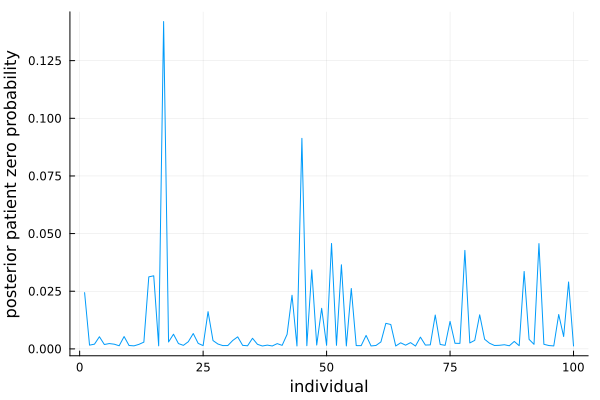

In [19]:
# computational constants
epsconv::Float64 = 1e-10 # convergence threshold
maxiter::Int = 5e2 # max number of iterations
damp::Float64 = 0.1 # damping factor
μ_cutoff::Float64 = -1 # cutoff for convergence

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

patient_zero_prob = [node.marg.m[2,1] for node in nodes]

plot(patient_zero_prob, xlabel = "individual", ylabel = "posterior patient zero probability", label = "")

## - SIR:

### System parameter definition and simulation

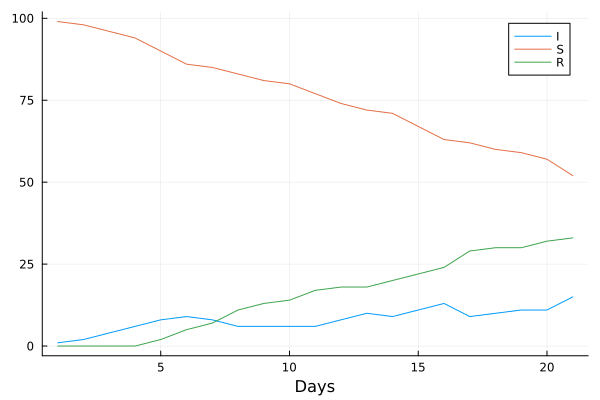

In [27]:
# define the constants
T::Int = 20 # total time
fₚ::Float64 = 0.0 # false-positive rate
fₙ::Float64 = 0.0 # false-negative rate
γ::Float64 = 1/NV # Patient zero probability
λ₀::Float64 = 0.3 # Infection rate
r₀::Float64 = 0.2 # Recovery rate
ε_autoinf::Float64 = 1e-10 # Self-infection rate
Nobs::Int = ceil(NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob::Float64, x::Float64)
    if Ob == -1.0
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SIR(ε_autoinf, r₀, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, patient_zero=[1])

# generate observations at the last time
obsmat = ones(nv(G), T+1) * (-1.0)
for (iₗ, τₗ) in sample(collect(Iterators.product(1:NV,ceil(Int,T*.5):T+1)), Nobs, replace = false)
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

# insert the observations into the model structure
model.obsmat .= obsmat

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
plot([nrI nrS nrR], xlabel = "Days", ylabel = "", label = ["I" "S" "R"])


### Inference

i = 1 ε = 0.9
i = 2 ε = 1.6858197322606752
i = 3 ε = 1.0275654801941247
i = 4 ε = 0.7146248701594178
i = 5 ε = 0.43742958323871084
i = 6 ε = 0.464852157013145
i = 7 ε = 0.26823593751600217
i = 8 ε = 0.16447457822744582
i = 9 ε = 0.08421845042179588
i = 10 ε = 0.07545155172701637
i = 11 ε = 0.0534406765351467
i = 12 ε = 0.024585819205755644
i = 13 ε = 0.008459672193665169
i = 14 ε = 0.00621582954528499
i = 15 ε = 0.005282196044071097
i = 16 ε = 0.0037562787558942934
i = 17 ε = 0.0021239542897660835
i = 18 ε = 0.0011785472823821475
i = 19 ε = 0.0007366025501026052
i = 20 ε = 0.0004788541913842148
i = 21 ε = 0.0002747963216594984
i = 22 ε = 0.00012148089763230896
i = 23 ε = 4.902516188864947e-5
i = 24 ε = 2.6363899231607313e-5
i = 25 ε = 1.836127993476433e-5
i = 26 ε = 1.5575886645635695e-5
i = 27 ε = 1.0356361154706395e-5
i = 28 ε = 6.119571925089495e-6
i = 29 ε = 3.3279625649140776e-6
i = 30 ε = 1.621233173931813e-6
i = 31 ε = 7.597268930625845e-7
i = 32 ε = 4.359666744280233e-7
i = 33 

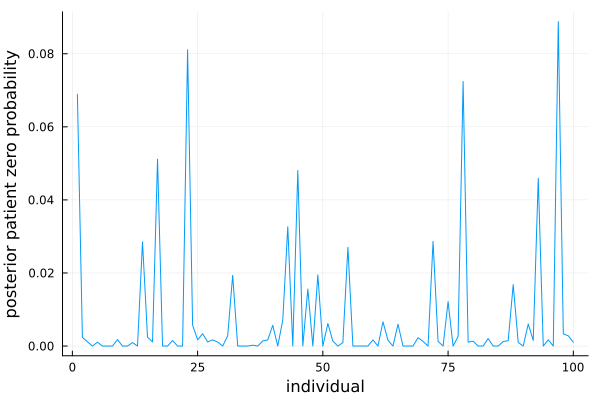

In [28]:
# computational constants
epsconv::Float64 = 1e-10 # convergence threshold
maxiter::Int = 5e2 # max number of iterations
damp::Float64 = 0.1 # damping factor
μ_cutoff::Float64 = -1 # cutoff for convergence

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

patient_zero_prob = [node.marg.m[2,1] for node in nodes]

plot(patient_zero_prob, xlabel = "individual", ylabel = "posterior patient zero probability", label = "")

## - SIRS:

### System parameter definition and simulation

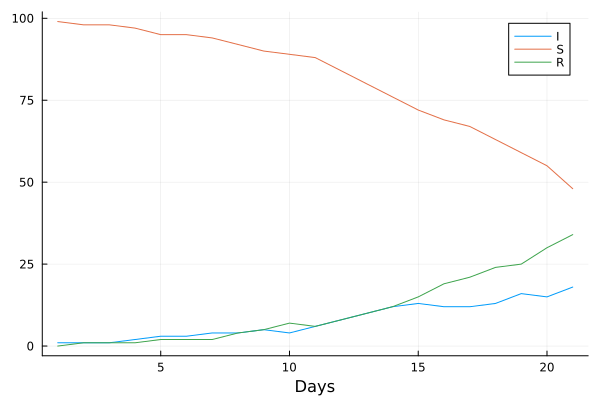

In [31]:
# define the constants
T::Int = 20 # total time
fₚ::Float64 = 0.0 # false-positive rate
fₙ::Float64 = 0.0 # false-negative rate
γ::Float64 = 1/NV # Patient zero probability
λ₀::Float64 = 0.3 # Infection rate
r₀::Float64 = 0.2 # Recovery rate
σ₀::Float64 = 0.02 # Immunity rate
ε_autoinf::Float64 = 1e-10 # Self-infection rate
Nobs::Int = ceil(NV*.75) # Number of observations

# define the observation probability
function obsprob(Ob::Float64, x::Float64)
    if Ob == -1.0
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SIRS(ε_autoinf, r₀, σ₀, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, patient_zero=[1])

# generate observations at the last time
obsmat = ones(nv(G), T+1) * (-1.0)
for (iₗ, τₗ) in sample(collect(Iterators.product(1:NV,ceil(Int,T*.5):T+1)), Nobs, replace = false)
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
end

# insert the observations into the model structure
model.obsmat .= obsmat

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
plot([nrI nrS nrR], xlabel = "Days", ylabel = "", label = ["I" "S" "R"])

### Inference

i = 1 ε = 0.9164928642038215
i = 2 ε = 1.366898204159952
i = 3 ε = 1.0560569402922244
i = 4 ε = 0.6809918738581028
i = 5 ε = 0.30735284939518887
i = 6 ε = 0.32478893750281645
i = 7 ε = 0.33838906380227407
i = 8 ε = 0.26344705245651445
i = 9 ε = 0.16486577529411317
i = 10 ε = 0.06413205101214914
i = 11 ε = 0.038214554327864025
i = 12 ε = 0.019285554261833315
i = 13 ε = 0.010331160155610197
i = 14 ε = 0.006070918037050954
i = 15 ε = 0.0037009505982957824
i = 16 ε = 0.0023305440199985483
i = 17 ε = 0.001466882277352366
i = 18 ε = 0.001220216538049379
i = 19 ε = 0.0007763178137023541
i = 20 ε = 0.00036948277068438173
i = 21 ε = 0.00017833179131054866
i = 22 ε = 0.00015303839434221977
i = 23 ε = 0.00011493043987209628
i = 24 ε = 7.239025696570422e-5
i = 25 ε = 3.998001963767539e-5
i = 26 ε = 2.174745747274276e-5
i = 27 ε = 8.676411253349947e-6
i = 28 ε = 5.38709394570791e-6
i = 29 ε = 4.631804176202792e-6
i = 30 ε = 2.886699358328748e-6
i = 31 ε = 1.2807523781521724e-6
i = 32 ε = 4.41641779

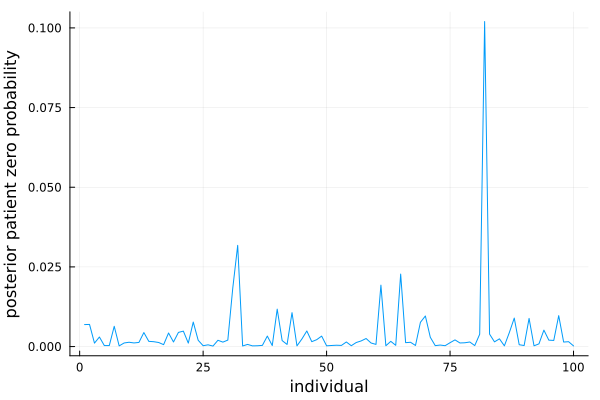

In [32]:
# computational constants
epsconv::Float64 = 1e-10 # convergence threshold
maxiter::Int = 5e2 # max number of iterations
damp::Float64 = 0.1 # damping factor
μ_cutoff::Float64 = -1 # cutoff for convergence

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

patient_zero_prob = [node.marg.m[2,1] for node in nodes]

plot(patient_zero_prob, xlabel = "individual", ylabel = "posterior patient zero probability", label = "")